In [2]:
#uncomment to download cifar10 dataset from https://course.fast.ai/datasets (already in png format)
#!wget https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz && tar -xzf cifar10.tgz && rm cifar10.tgz

--2021-09-08 13:22:48--  https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.136.133
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.136.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135107811 (129M) [application/x-tar]
Saving to: ‘cifar10.tgz’

cifar10.tgz         100%[===================>] 128.85M   500KB/s    in 5m 27s  

2021-09-08 13:28:16 (403 KB/s) - ‘cifar10.tgz’ saved [135107811/135107811]



In [46]:
#training parameters:
bs = 256
img_dim_load = 128 # this is larger than the input 32x32; givings augmentations a larger chance to pad/augment
img_dim_cif = 96  # this is also larger than the input; giving model larger receptive field

In [47]:
def files_in_subdirs(start_dir, pattern = ["*.png","*.jpg","*.jpeg"]):
    files = []
    for p in pattern:
        for dir,_,_ in os.walk(start_dir):
            files.extend(glob.glob(os.path.join(dir,p)))
    return files
cifar10_train = files_in_subdirs('./cifar10/train')
cifar10_val = files_in_subdirs('./cifar10/test')
cifar10_paths = cifar10_val+cifar10_train
print("Loaded: ",len(cifar10_train), len(cifar10_val))

Loaded:  50000 10000


Using:  50000 10000 0


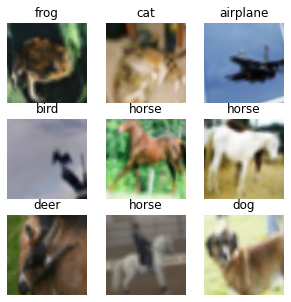

In [48]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import glob, os, re, sys
from fastai2.data.transforms import RegexLabeller
from fastai2.vision.all import aug_transforms, Normalize, DataBlock, ImageBlock, CategoryBlock, Resize, IndexSplitter

from torchvision.transforms import RandomCrop, RandomHorizontalFlip

get_cls = RegexLabeller(pat = r'.*/(.*)/')
#default fastai augmentations (reflective padding, horizontal flipping, up to 10 deg rotation;)
#see https://docs.fast.ai/vision.augment.html#aug_transforms
#parameters based on https://gist.github.com/rlandingin/e09e2e568e964466fc3b5634bf18d87a
tfms = [*aug_transforms(size=img_dim_cif, min_scale=0.8, max_zoom=1.1, max_lighting=0.4),
        Normalize.from_stats(mean=[0.4914 , 0.48216, 0.44653], std=[0.24703, 0.24349, 0.26159])]  

#creating a DataBlock 'from_folder' would work but we want to exclude or dublicate images later
# (i.e. redundancy) -> this can be easily achived using file paths
dblock = DataBlock(
  blocks=(ImageBlock, CategoryBlock),      # one image input and one categorical target
  splitter=IndexSplitter(range(0,len(cifar10_val))),
  batch_tfms=tfms,
  item_tfms=[Resize(img_dim_cif)],
  get_items = lambda x:(cifar10_paths),
  get_y     =  get_cls)
ods_train = dblock.dataloaders('./',bs=bs)
ods_train.show_batch(max_n=9 , figsize=(5,5))
bad_valid = [t for t in ods_train.valid_ds.items if not '/test/' in t] #just a precaution to make sure validation frames are not in the training set
print("Using: ", len(ods_train.train_ds.items), len(ods_train.valid_ds.items), len(bad_valid))

In [49]:
import torch
from torchvision.models import resnet34
from fastai2.vision.all import cnn_learner, accuracy
learn = cnn_learner(ods_train, resnet34, metrics=accuracy, pretrained=True)
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0, 1])
learn.fit_one_cycle(10)#, max_lr=slice(1e-6,1e-4))

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time
0,1.417541,0.661124,0.788900,00:26
1,0.598193,0.380321,0.876900,00:25
2,0.407884,0.287336,0.902000,00:25
3,0.343769,0.264965,0.910200,00:25
4,0.313208,0.264297,0.911900,00:24
5,0.289462,0.234725,0.919600,00:25
6,0.270628,0.231942,0.920100,00:25
7,0.253871,0.224791,0.923200,00:25
8,0.247780,0.223032,0.925200,00:25
9,0.246054,0.221009,0.924900,00:25


In [50]:
learn.unfreeze()
learn.fit_one_cycle(10 , max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.331868,0.415994,0.866500,00:28
1,0.409594,0.773187,0.791400,00:27
2,0.390172,0.546835,0.821200,00:27
3,0.347704,0.438442,0.850400,00:27
4,0.270937,0.285303,0.905600,00:27
5,0.216716,0.268660,0.911500,00:28
6,0.155293,0.188169,0.939500,00:27
7,0.106909,0.171989,0.945500,00:27
8,0.077271,0.153902,0.950000,00:27
9,0.062090,0.150984,0.952200,00:27


In [52]:
from fastai2.vision.all import ProgressCallback
learn.remove_cb(ProgressCallback) #necessary due to strange bug (see https://github.com/fastai/fastprogress/issues/72)
res = learn.tta(n=10)
print("Accuracy (tta) :", float(accuracy(*res)))

Accuracy (tta) : 0.958899974822998


This Accuracy is on par with the current best results at the paperswithcode public leaderboard:

https://paperswithcode.com/sota/image-classification-on-cifar-10

Best comparable entry (ResNet32) has 95.35